In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score

import optimization as opt
import oracles as orc
from scipy.sparse import diags

In [5]:
colors = ['b', 'g', 'c', 'r', 'y', 'm']

# Эксперимент 1.

In [3]:
def experiment_1(n_values, colors, seed=517, n_starts=10, tolerance=1e-10):
   
    np.random.seed(seed)
    plt.figure(figsize=(10, 6))
    plt.ylabel('Iterations until convergence')
    plt.xlabel('Condition number')
    plt.title('Conjugate Gradients on a quadratic')
    
    kappa_values = np.arange(2, 1000, 50)
    iters_info = np.zeros((n_values.shape[0], 
                        kappa_values.shape[0],
                       n_starts)).astype('int')
    for i, n in enumerate(n_values):
        x_0 = np.zeros(n)
        for j, kappa in enumerate(kappa_values):
            for n_start in range(n_starts):
                A = np.concatenate(([1], [kappa], np.random.uniform(low=1.0, high=kappa, size=n-2)))
                A = np.random.permutation(A)
                A = diags(A)
                b = np.random.randn(n)
                x_star, msg, history = opt.conjugate_gradients(lambda x: A.dot(x), b, 
                                                               x_0, trace=True, tolerance=tolerance)
                iters_info[i, j, n_start] = len(history['time']) + 1
        for n_start in range(n_starts):
            plt.plot(kappa_values, iters_info[i, :, n_start], c=colors[i], alpha=0.5, linestyle='--')
        plt.plot(kappa_values, iters_info[i, :, :].mean(axis=1), c=colors[i], lw=4, label='n = ' + str(n))
    plt.grid()
    plt.legend(loc=2)

CPU times: user 1min 8s, sys: 637 ms, total: 1min 8s
Wall time: 1min 8s


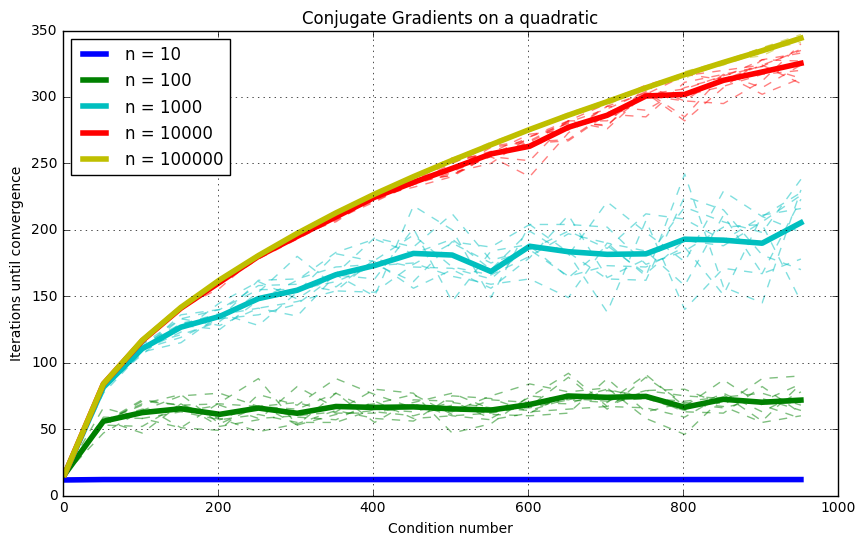

In [4]:
%%time
n_values = np.array([10, 100, 1000, 10000, 100000])
experiment_1(n_values, colors)
plt.savefig('report/images/experiment1/1.png')

# Эксперимент 2.

In [5]:
def experiment_2(filename, colors, l_vals):
    f, axxr = plt.subplots(1, 2)
    f.set_figheight(6)
    f.set_figwidth(13)
    A, b = load_svmlight_file(filename)
    m, n = A.shape
    f.suptitle('Running on ' + filename + ' dataset (m = ' + str(m) + ', n = ' + str(n) + ')', 
               fontsize=16)
    regcoef = 1. / m
    x_0 = np.zeros(n)
    oracle = orc.create_log_reg_oracle(A, b, regcoef, oracle_type='optimized')
    legend = ['l = ' + str(l) for l in l_vals]
    axxr[0].grid()
    axxr[0].set_yscale('log')
    axxr[0].set_xlabel('Iterations')
    axxr[0].set_ylabel('grad_norm$(x_k)^2$ / grad_norm$(x_0)^2$')
    
    
    axxr[1].grid()
    axxr[1].set_yscale('log')
    axxr[1].set_xlabel('Time (sec)')
    axxr[1].set_ylabel('grad_norm$(x_k)^2$ / grad_norm$(x_0)^2$')

    for i, l in enumerate(l_vals):
        lbfgs_x_star, lbfgs_message, lbfgs_history = opt.lbfgs(oracle, x_0, trace=True, 
                                                               memory_size=l, tolerance=1e-7)
        y = np.array(lbfgs_history['grad_norm']) ** 2 / lbfgs_history['grad_norm'][0] ** 2
        axxr[0].plot(np.arange(1, len(y) + 1), y, c=colors[i], lw=3)
        axxr[1].plot(lbfgs_history['time'], y, c=colors[i], lw=3)
    
    axxr[0].legend(legend)
    axxr[1].legend(legend)

/root/anaconda3/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


CPU times: user 2min 6s, sys: 2.28 s, total: 2min 9s
Wall time: 2min 8s


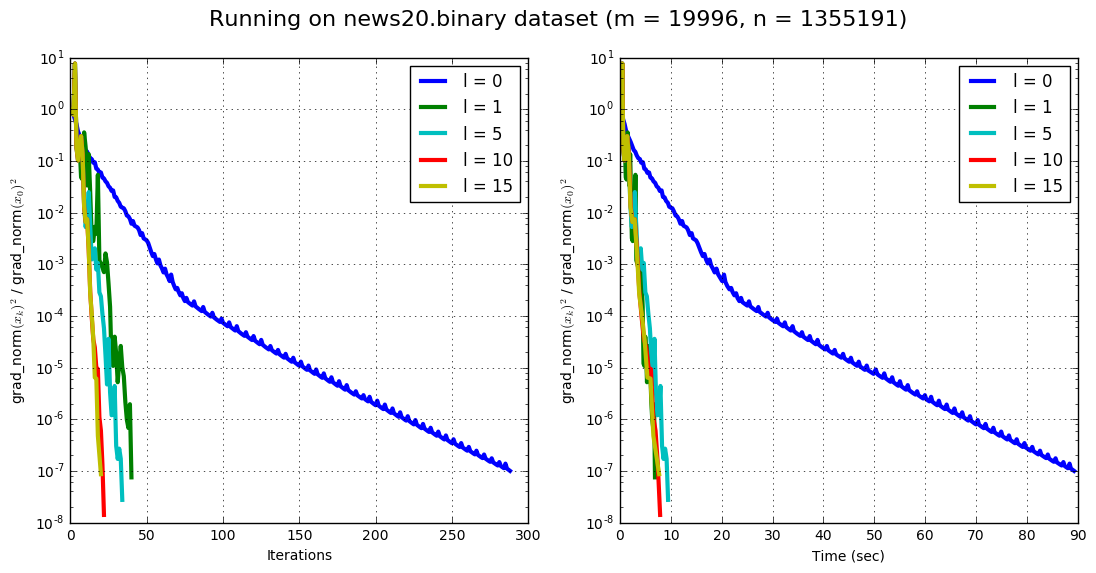

In [6]:
%%time
l_vals = [0, 1, 5, 10, 15]
experiment_2("news20.binary", colors, l_vals)
plt.savefig('report/images/experiment2/1.png')

# Эксперимент 3.

In [3]:
def experiment_3(filename, colors):
    f, axxr = plt.subplots(1, 3)
    f.set_figheight(4)
    f.set_figwidth(15)
    A, b = load_svmlight_file(filename)
    m, n = A.shape
    f.suptitle('Running on ' + filename + ' dataset (m = ' + str(m) + ', n = ' + str(n) + ')', 
               fontsize=16)
    regcoef = 1. / m
    x_0 = np.zeros(n)
    oracle = orc.create_log_reg_oracle(A, b, regcoef, oracle_type='optimized')
    
    gd_x_star, gd_message, gd_history = opt.gradient_descent(oracle, x_0, trace=True, tolerance=1e-5)
    hfn_x_star, hfn_message, hfn_history = opt.hessian_free_newton(oracle, x_0, trace=True, tolerance=1e-5)
    lbfgs_x_star, lbfgs_message, lbfgs_history = opt.lbfgs(oracle, x_0, trace=True, tolerance=1e-5)
    
    axxr[0].grid()
    axxr[0].plot(np.arange(1, len(gd_history['func']) + 1), gd_history['func'], c=colors[0], lw=3)
    axxr[0].plot(np.arange(1, len(hfn_history['func']) + 1), hfn_history['func'], c=colors[1], lw=3)
    axxr[0].plot(np.arange(1, len(lbfgs_history['func']) + 1), lbfgs_history['func'], c=colors[2], lw=3)
    axxr[0].legend(['Gradient Descent', 'Hessian Free Newton', 'L-BFGS'])
    axxr[0].set_xlabel('Number of iteration')
    axxr[0].set_ylabel('Func value')
    
    axxr[1].grid()
    axxr[1].plot(gd_history['time'], gd_history['func'], c=colors[0], lw=3)
    axxr[1].plot(hfn_history['time'], hfn_history['func'], c=colors[1], lw=3)
    axxr[1].plot(lbfgs_history['time'], lbfgs_history['func'], c=colors[2], lw=3)
    axxr[1].legend(['Gradient Descent', 'Hessian Free Newton', 'L-BFGS'])
    axxr[1].set_xlabel('Time (sec)')
    axxr[1].set_ylabel('Func value')
    
    axxr[2].grid()
    axxr[2].set_yscale('log')
    y = np.array(gd_history['grad_norm']) ** 2 / gd_history['grad_norm'][0] ** 2
    axxr[2].plot(gd_history['time'], y, c=colors[0], lw=3)
    
    y = np.array(hfn_history['grad_norm']) ** 2 / hfn_history['grad_norm'][0] ** 2
    axxr[2].plot(hfn_history['time'], y, c=colors[1], lw=3)
    
    y = np.array(lbfgs_history['grad_norm']) ** 2 / lbfgs_history['grad_norm'][0] ** 2
    axxr[2].plot(lbfgs_history['time'], y, c=colors[2], lw=3)
    
    axxr[2].legend(['Gradient Descent', 'Hessian Free Newton', 'L-BFGS'])
    axxr[2].set_xlabel('Time (sec)')
    axxr[2].set_ylabel('grad_norm$(x_k)^2$ / grad_norm$(x_0)^2$')

CPU times: user 3.11 s, sys: 779 ms, total: 3.89 s
Wall time: 3.06 s


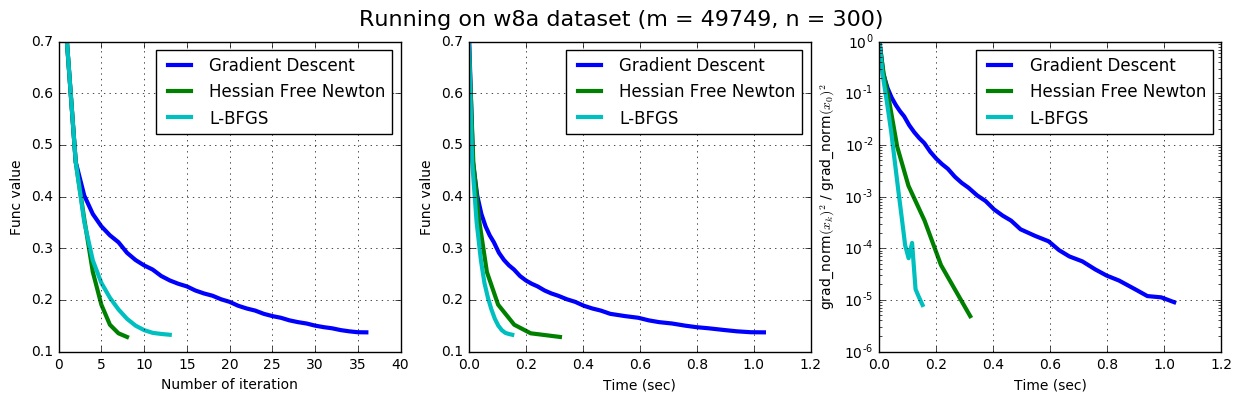

In [4]:
%%time
experiment_3('w8a', colors)
plt.savefig('report/images/experiment3/1.png')

CPU times: user 2min 19s, sys: 947 ms, total: 2min 20s
Wall time: 2min 19s


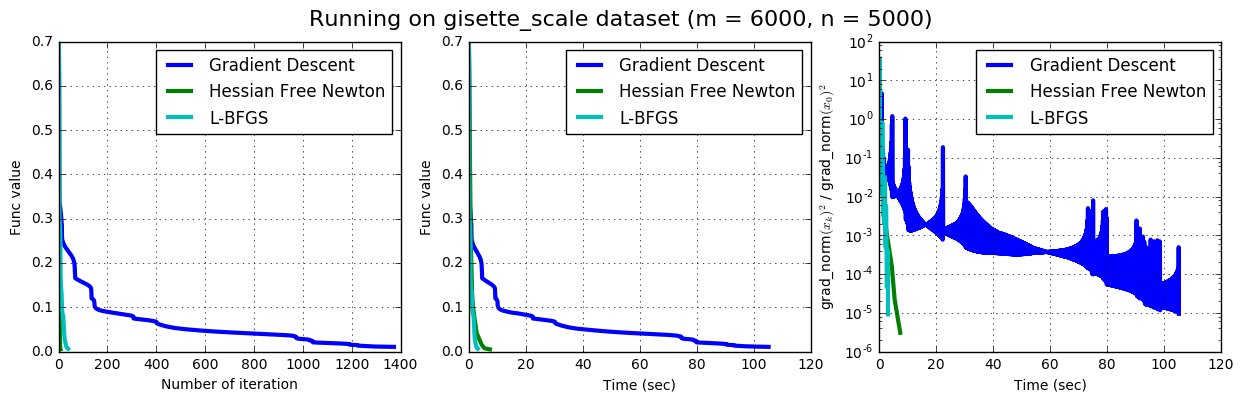

In [5]:
%%time
experiment_3('gisette_scale', colors)
plt.savefig('report/images/experiment3/2.png')

/root/anaconda3/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


CPU times: user 1min 10s, sys: 1.77 s, total: 1min 12s
Wall time: 1min 11s


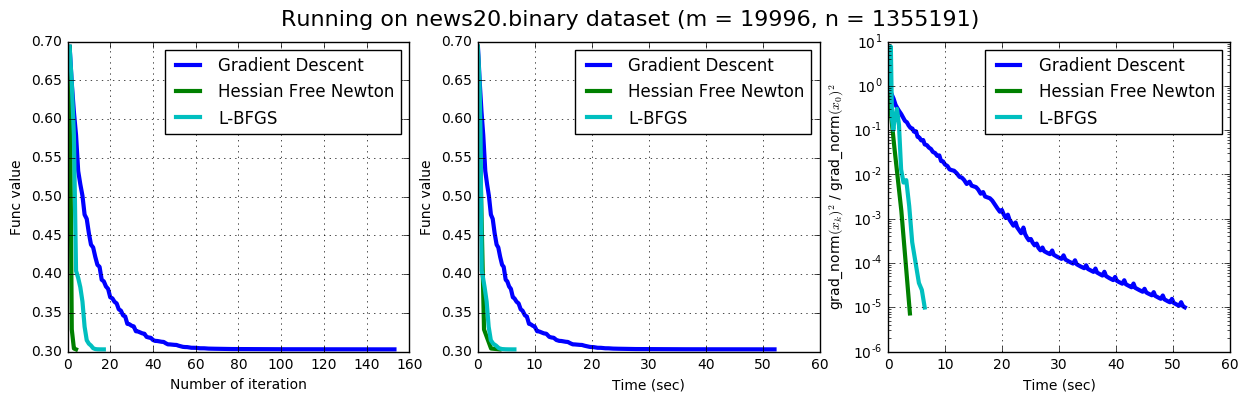

In [6]:
%%time
experiment_3('news20.binary', colors)
plt.savefig('report/images/experiment3/3.png')

/root/anaconda3/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


CPU times: user 15.2 s, sys: 852 ms, total: 16 s
Wall time: 15.2 s


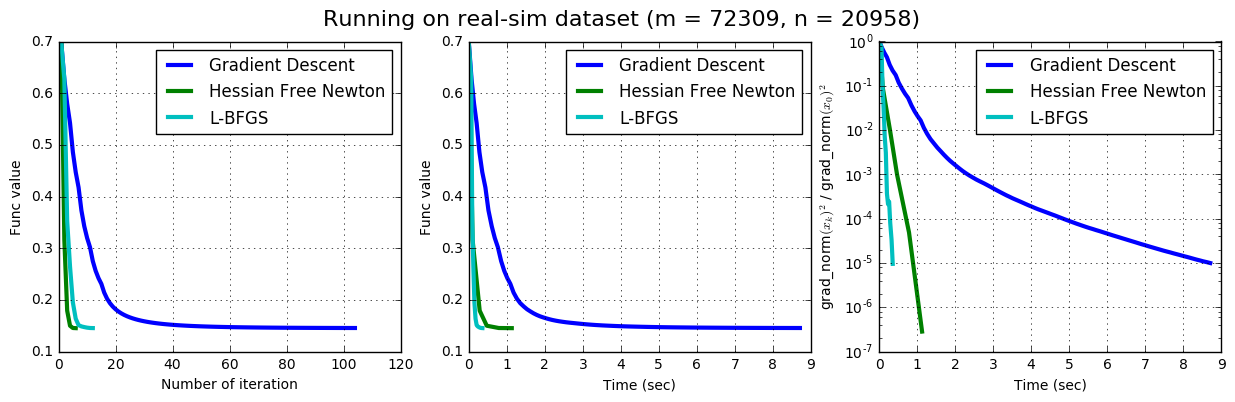

In [7]:
%%time
experiment_3('real-sim', colors)
plt.savefig('report/images/experiment3/4.png')

/root/anaconda3/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


CPU times: user 4.79 s, sys: 848 ms, total: 5.63 s
Wall time: 4.78 s


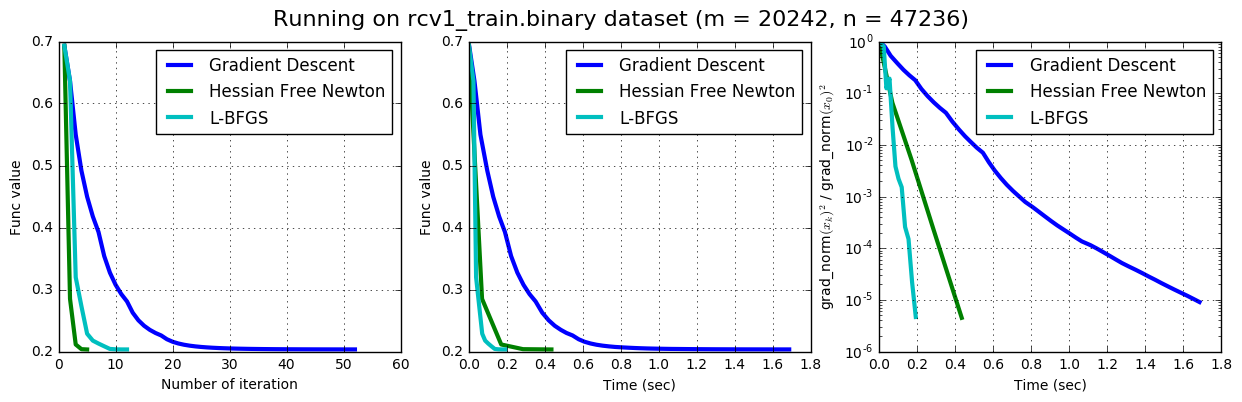

In [8]:
%%time
experiment_3('rcv1_train.binary', colors)
plt.savefig('report/images/experiment3/5.png')

# Эксперимент 4.

In [2]:
def experiment_4(n, kappa_vals, colors, seed=517):
    np.random.seed(seed)
    f, axxr = plt.subplots(1, 2)
    f.set_figheight(6)
    f.set_figwidth(13)
    l_vals = np.array([0, 1, 10, 50])
    legend = ['LBFGS, ' + 'l=' + str(l) for l in l_vals] + ['CG']
    
    x_0 = np.zeros(n)
    
    for i in range(2):
        axxr[i].set_yscale('log')
        axxr[i].set_ylabel('Residual norm')
        axxr[i].set_xlabel('Number of iteration')
        kappa = kappa_vals[i]
        A = np.concatenate(([1], [kappa], np.random.uniform(low=1.0, high=kappa, size=n-2)))
        A = np.random.permutation(A)
        A = diags(A)
        b = np.random.randn(n)
        
        oracle = orc.QuadraticOracle(A, b)
        for j, l in enumerate(l_vals):
            lbfgs_x_star, lbfgs_msg, lbfgs_history = opt.lbfgs(oracle, x_0, memory_size=l,
                                                               line_search_options={'method': 'Best'}, 
                                                               trace=True, tolerance=1e-16, max_iter=2000)
            axxr[i].plot(np.arange(1, len(lbfgs_history['grad_norm']) + 1), lbfgs_history['grad_norm'], 
                         c=colors[j], lw=7-j)
        cg_x_star, cg_msg, cg_history = opt.conjugate_gradients(lambda x: A.dot(x), b, x_0, trace=True, tolerance=1e-8)
        axxr[i].plot(np.arange(1, len(cg_history['residual_norm']) + 1), cg_history['residual_norm'], 
                     c=colors[4], linestyle='--')
        axxr[i].set_title('Condition number = ' + str(kappa))
        axxr[i].legend(legend)

CPU times: user 8.59 s, sys: 1.9 s, total: 10.5 s
Wall time: 10.3 s


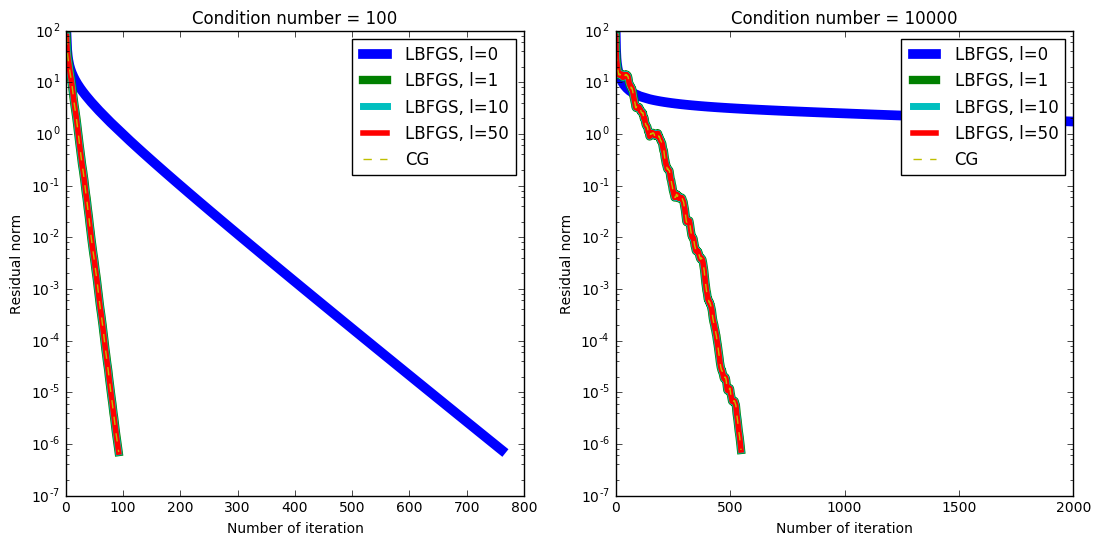

In [6]:
%%time
n = 6000
kappa_vals = [100, 10000]
experiment_4(n, kappa_vals, colors)
plt.savefig('report/images/experiment4/1.png')

# Эксперимент 5.

In [48]:
def experiment_5(filename_train, filename_test, colors, tolerances):
    plt.figure(figsize=(10, 7))
    A_train, b_train = load_svmlight_file(filename_train)
    A_test, b_test = load_svmlight_file(filename_test)
    m_train, n = A_train.shape
    m_test, n = A_test.shape
    plt.title('Running on ' + filename_train + ' dataset (m_train = ' + str(m_train) + ', n = ' + str(n) + ')', 
               fontsize=16)
    regcoef = 1. / m_train
    x_0 = np.zeros(n)
    oracle = orc.create_log_reg_oracle(A_train, b_train, regcoef, oracle_type='optimized')
    
    accuracy = []
    
    for i, tol in enumerate(tolerances):
        x_star, msg, history = opt.lbfgs(oracle, x_0, tolerance=tol, 
                                         max_iter=10000)
        accuracy.append(accuracy_score(np.sign(A_test.dot(x_star)), b_test))
    
    plt.xscale('log')
    plt.xlabel('Tolerance')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.gca().invert_xaxis()
    plt.plot(tolerances, accuracy, lw=3, c=colors[1])

CPU times: user 49.9 s, sys: 504 ms, total: 50.4 s
Wall time: 50 s


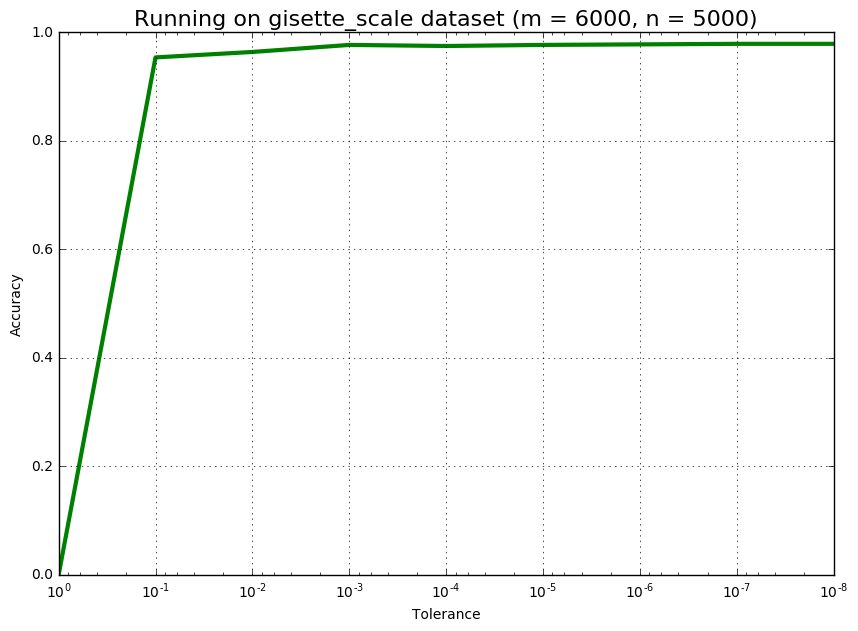

In [49]:
%%time
tolerances = [1., 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
experiment_5("gisette_scale", "gisette_scale_test", colors, tolerances)
plt.savefig('report/images/experiment5/1.png')

CPU times: user 2.48 s, sys: 384 ms, total: 2.86 s
Wall time: 2.44 s


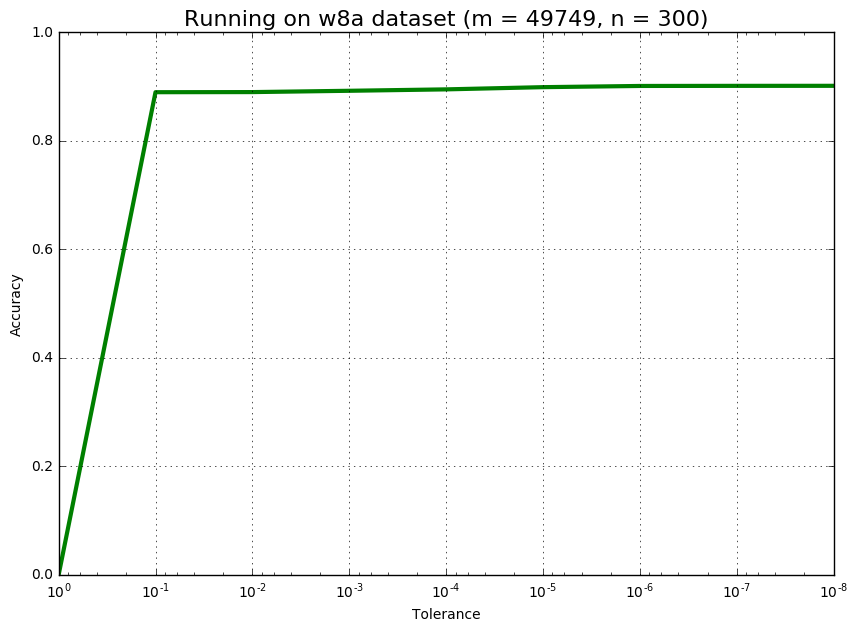

In [50]:
%%time
tolerances = [1., 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
experiment_5("w8a", "w8a_test", colors, tolerances)
plt.savefig('report/images/experiment5/2.png')